In [72]:
import pathlib
import warnings

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import statsmodels.api as sm
from matplotlib import pyplot as plt
from plotly.io import write_html, write_image
from plotly.offline import init_notebook_mode, plot
from statsmodels.graphics.gofplots import qqplot_2samples

import wristpy
from wristpy.common import data_model
from wristpy.common.data_model import OutputData
from wristpy.ggir import calibration, compare_dataframes, metrics_calc
from wristpy.io.loaders import gt3x

# Ignore all warnings
warnings.filterwarnings('ignore')



init_notebook_mode(connected=True)

# Functions

These are recreations of the plotting functions in comapre dataframes, as well as the runner.py.
Using these for the experimental purposes of this notebook, and are not strictly speaking necessary. 

In [73]:
def plot_enmo(
    difference_df: pl.DataFrame,
    outputdata_trimmed: pl.DataFrame,
    ggir_dataframe: pl.DataFrame,
    opacity: float,
    indices: slice = slice(None),
    save_plot: bool = True,
    save_path: str = None
) -> None:
    """Plot difference graphs for enmo, with user defined indices and opacity.

    Args:
        difference_df: Dataframe with time and error difference
        outputdata_trimmed: Dataframe with the outputData class trimmed for GGIR comparison
        ggir_dataframe: Dataframe with ggir data
        indices: user defined indices to plot
        opacity: For data overlay visibility

        Returns:None
    """
    fig = go.Figure()

    # Add the trimmed ENMO from outputdata_trimmed
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=outputdata_trimmed["trim_enmo"],
                            mode='lines',
                            line=dict(color='green', width=2),
                            name='Wristpy ENMO (Trimmed)',
                            opacity=opacity))

    # Add the ENMO from ggir_dataframe
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=ggir_dataframe["ENMO"],
                            mode='lines+markers', # Change to 'lines' if you don't want markers
                            line=dict(color='red', dash='dash', width=2),
                            name='GGIR ENMO',
                            opacity=opacity))

    # Add the ENMO difference
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=difference_df["enmo_diff"],
                            mode='lines',
                            line=dict(color='black', width=2),
                            name='ENMO Difference'))

    # Update layout if needed (e.g., titles, axes labels)
    fig.update_layout(title='ENMO Comparison',
                    xaxis_title='Time',
                    yaxis_title='ENMO Values',
                    legend_title='Legend')

    # Show the figure
    fig.show(renderer = 'png')
    if save_plot:
        plot(fig, filename=save_path, auto_open= False, include_plotlyjs='cdn')

def plot_anglez(
    difference_df: pl.DataFrame,
    outputdata_trimmed: pl.DataFrame,
    ggir_dataframe: pl.DataFrame,
    opacity: float,
    indices: slice = slice(None),
    save_plot: bool = True,
    save_path: str = None
) -> None:
    """Plot difference graphs for angelz, with user defined indices and opacity.

    Args:
        difference_df: Dataframe with time and error difference
        outputdata_trimmed: Dataframe with the outputData class trimmed for GGIR comparison
        ggir_dataframe: Dataframe with ggir data
        indices: user defined indices to plot
        opacity: For data overlay visibility

        Returns:None
    """
    fig = go.Figure()

    # Add the trimmed anglez from outputdata_trimmed
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=outputdata_trimmed["trim_anglez"],
                            mode='lines',
                            line=dict(color='green', width=2),
                            name='Wristpy Anglez (Trimmed)',
                            opacity=opacity))

    # Add the anglez from ggir_dataframe
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=ggir_dataframe["anglez"],
                            mode='lines+markers', # Change to 'lines' if you don't want markers
                            line=dict(color='red', dash='dash', width=2),
                            name='GGIR Anglez',
                            opacity=opacity
                            ))

    # Add the anglez difference
    fig.add_trace(go.Scatter(x=difference_df["time_trimmed"],
                            y=difference_df["anglez_diff"],
                            mode='lines',
                            line=dict(color='black', width=2),
                            name='Anglez Difference'))

    # Update the layout with titles and labels
    fig.update_layout(title='Anglez Comparison',
                    xaxis_title='Time',
                    yaxis_title='Anglez Values',
                    legend_title='Legend')

    # Show the figure
    fig.show(renderer = 'png')

    if save_plot:
        plot(fig, filename=save_path, auto_open= False, include_plotlyjs='cdn')

def plot_qq(
        output_data_trimmed: pl.DataFrame,
        ggir_data1: pl.DataFrame,
        save_plot: bool = True,
        save_path:str = None
)->None:
    """Creates a QQ plot.

    Args:
        output_data_trimmed: dataframe output by wristpy and trimmed to match the length 
        of the ggir output
        ggir_data1: dataframe output by ggir.

    Returns:
        Returns None
    """
    pp_x = sm.ProbPlot(output_data_trimmed['trim_enmo'])
    pp_y = sm.ProbPlot(ggir_data1['ENMO'])
    qqplot_2samples(pp_x, pp_y, line="r")

    plt.savefig(save_path)
    plt.show()

def plot_ba(
        output_data_trimmed: pl.DataFrame,
        ggir_data1: pl.DataFrame,
        save_plot: bool = True,
        save_path: str = None
)->None:
    """Creates a Bland Altman plot.

    Args:
        output_data_trimmed: dataframe output by wristpy and trimmed to match the length 
        of the ggir output
        ggir_data1: dataframe output by ggir.

    Returns:
        None 
    """
    opac_dict = dict(alpha=0.5)
    f, ax = plt.subplots(1, figsize = (8,5))
    sm.graphics.mean_diff_plot(np.asarray(output_data_trimmed['trim_enmo']), np.asarray(ggir_data1['ENMO']), ax = ax, scatter_kwds=opac_dict)
    plt.savefig(save_path)
    plt.show()

def log_diff(
    difference_df: pl.DataFrame,
    outputdata_trimmed: pl.DataFrame,
    ggir_dataframe: pl.DataFrame,
    opacity: float,
    measures: str,
    indices: slice = slice(None),
    save_plot: bool = True,
    save_path: str = None
) -> None:
    """Plot difference graphs, with user defined indices, opacity and measures.

    Args:
        difference_df: Dataframe with time and error difference
        outputdata_trimmed: Dataframe with the outputData class trimmed for GGIR comparison
        ggir_dataframe: Dataframe with ggir data
        indices: user defined indices to plot
        opacity: For data overlay visibility
        measures: user defined measure to plot and compare.

        Returns:None
    """
    if measures == "ENMO":
        enmo_save_path = f"{save_path}_{measures}.html" if save_path else None
        plot_enmo(
            difference_df= difference_df,
            outputdata_trimmed= outputdata_trimmed,
            ggir_dataframe= ggir_dataframe,
            indices= indices,
            opacity = opacity,
            save_plot = save_plot,
            save_path = enmo_save_path)
    elif measures == "anglez":
        anglez_save_path = f"{save_path}_{measures}.html" if save_path else None
        plot_anglez(
            difference_df= difference_df,
            outputdata_trimmed= outputdata_trimmed,
            ggir_dataframe= ggir_dataframe,
            indices= indices,
            opacity = opacity,
            save_plot = save_plot,
            save_path = anglez_save_path)
    elif measures == "qq":
        qq_save_path = f"{save_path}_{measures}.pdf" if save_path else None
        plot_qq(
            output_data_trimmed= outputdata_trimmed,
            ggir_data1 = ggir_dataframe,
            save_plot= save_plot,
            save_path= qq_save_path)
    elif measures == "ba":
        ba_save_path = f"{save_path}_{measures}.pdf" if save_path else None
        plot_ba(
            output_data_trimmed= outputdata_trimmed,
            ggir_data1 = ggir_dataframe,
            save_plot= save_plot,
            save_path= ba_save_path)
    else:
        print("YOU DID NOT SELECT A MEASURE!")

In [78]:
def notebook_runner(gt3x_file_path: str, ggir_output_path: str, measures_to_plot: list,
                    save_plot: bool = True, save_path: str = None)-> None: 
    #pick file, load data, if not using ACTFAST, this cell will be slow
    test_config = wristpy.common.data_model.Config(gt3x_file_path, gt3x_file_path)
    test_data = gt3x.load(test_config.path_input)


    #Calibrate and run metrics 
    test_output = calibration.start_ggir_calibration(test_data)
    metrics_calc.calc_base_metrics(test_output)
    metrics_calc.calc_epoch1_metrics(test_output)
    ggir_data = compare_dataframes.load_ggir_output(ggir_output_path)

    #calculate differences
    difference_df, outputdata_trimmed = compare_dataframes.compare(
                                        ggir_dataframe= ggir_data,
                                        wristpy_dataframe=test_output
    )

    for measure in measures_to_plot:
            log_diff(
                outputdata_trimmed = outputdata_trimmed, 
                ggir_dataframe = ggir_data, 
                difference_df = difference_df,
                measures=measure, 
                opacity= 0.5,
                save_plot = save_plot,
                save_path = save_path)



# Paths 

edit the paths here as needed 

In [80]:
#Put the paths to where files are kept here
path_to_raw = '/Users/freymon.perez/Documents/raw_gt3x_data_archive/'
path_to_ggir_output = '/Users/freymon.perez/Documents/ggir_raw_outputs_group1/'
path_to_save = '/Users/freymon.perez/Documents/plots/'

# Subject Logs

ENMO and anglez plots will be static in the notebook, but they will be saved as interactive html files.
ba and qq plots will be saved as static pdfs. 


## 1. NDARHE283KZN

* Idle Sleep mode datafill in by GGIR when wristpy records no activity 
* Repeated value of 1.1704 at 17:36 on everyday 
* 17:36 pattern does not occure on second day (02-28-2019)

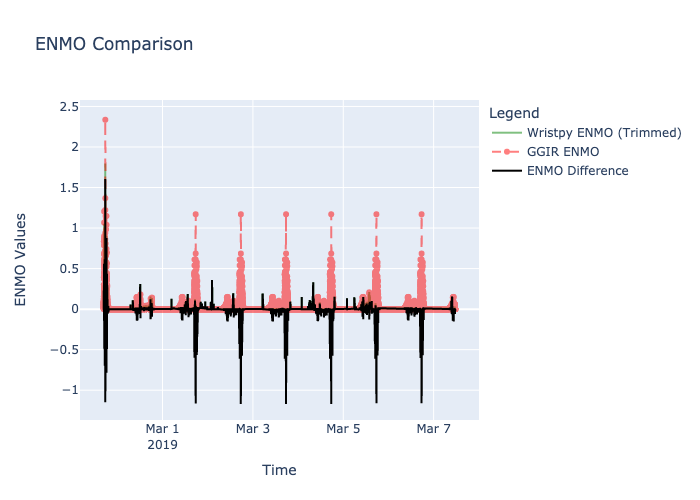

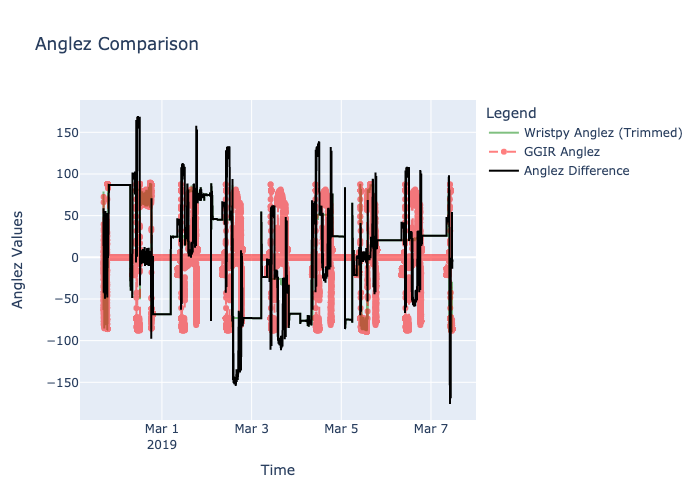

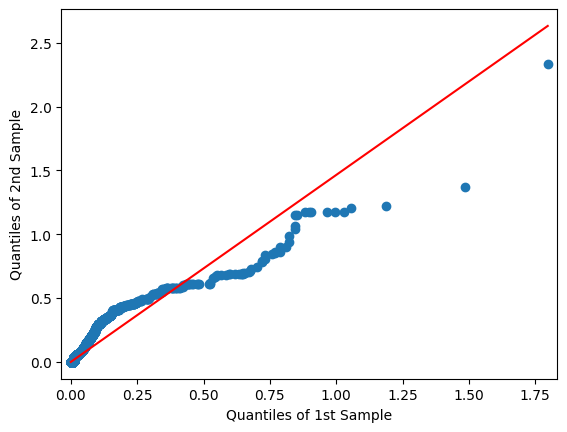

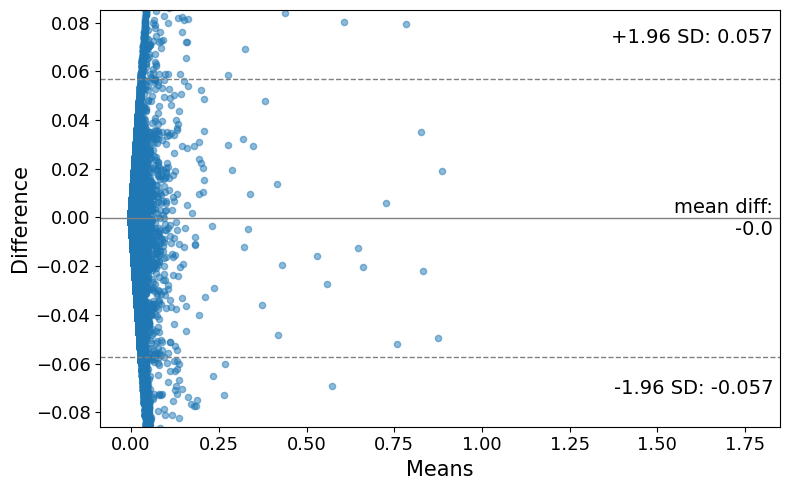

In [49]:
subject = 'NDARHE283KZN'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 2. NDARAR991JAA

* Activity data is largely in agreement except during extended periods of non-wear. 

* ENMO:
    1. GGIR fills in data when wristpy reports no activity, this data always follows a specific, regular pattern. 
    2. wristpy reports activity in the middle of a "non-wear" period, but GGIR continues to report the same pattern of activity. It then tapers off and realigns with the wristpy signal. 

* AngleZ error:
    1. Biggests difference in signal seems to be during non-wear period and largely in negative direction. 
    2. During wear periods there is a consistant, but non-trivial amount of difference between the two signals in both directions. 


    
* Example:
    *   see initial period where GGIR reports activity 2h 44 minutes before wristpy reports any (14:30 vs 17:14)
    *   from 17:14 - 20:02 both packages report activity, but the sigals are not aligned.
    * GGIR activity then tapers off until it reaches near zero until activity is detected again ~07:30
    *   This pattern can be seen in angleZ data as well


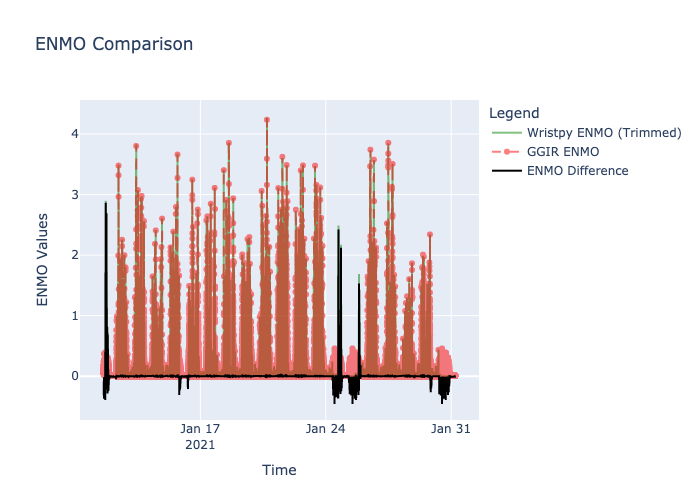

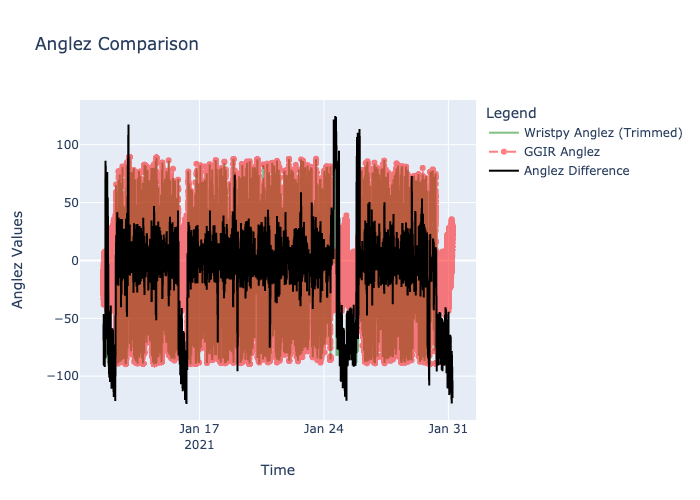

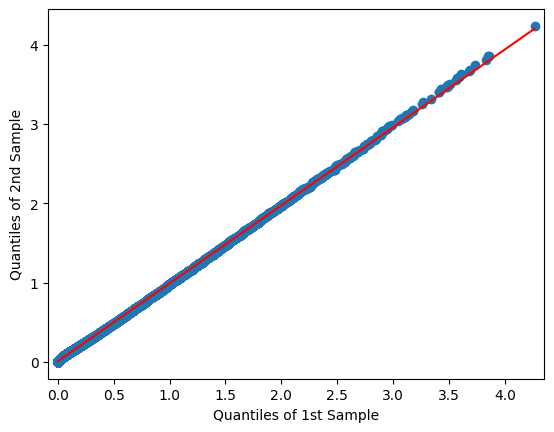

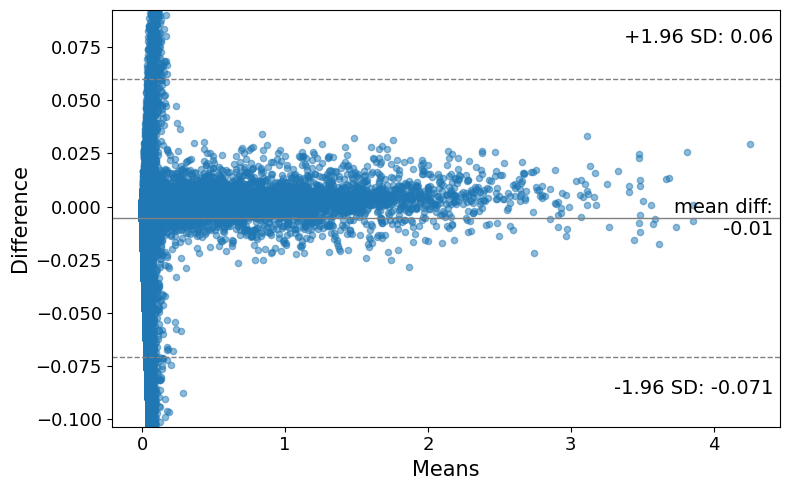

In [82]:
subject = 'NDARAR991JAA'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

In [71]:
import importlib
importlib.reload(gt3x)

<module 'wristpy.io.loaders.gt3x' from '/Users/freymon.perez/Projects/wristpy/src/wristpy/io/loaders/gt3x.py'>

## 3. NDARBF575JUL

*   ENMO:
    *  Difference between two packages where wristpy reports no activity, GGIR fills in, with a consistant pattern.
    *  Signals line up very well after wristpy begins to report activity.
    *  High difference when activity resumes part way through.  
    *  After day 3 (April 21,2021 @ 06:00) a consistant error of ~ +/- 1 appears through out the rest of the data set.
        * This difference does not seem to be due to idle sleep mode?  
*   AngleZ:
    *   Periods of Non wear result in specfic "default" GGIR signal, where wristpy registers around +/- ~90 degrees
        * Could indicate the watch being taken off and set down (face down/up?) 


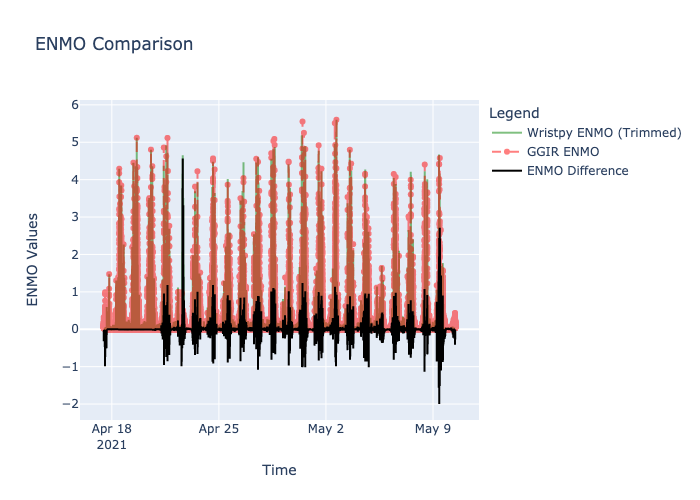

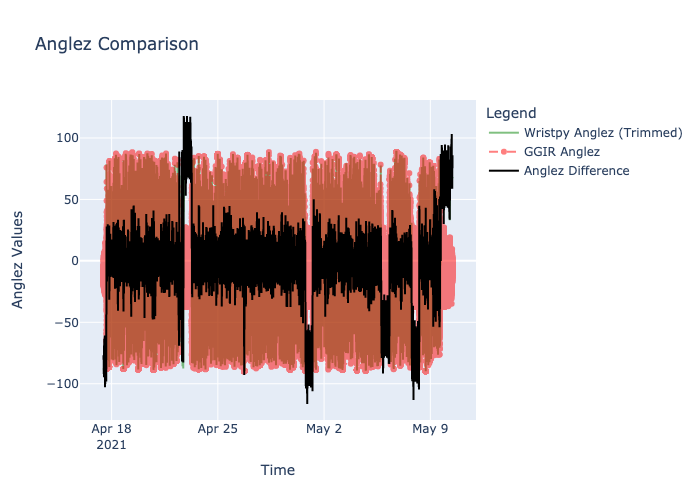

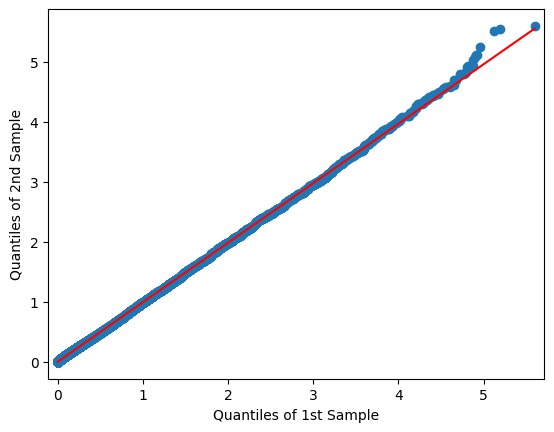

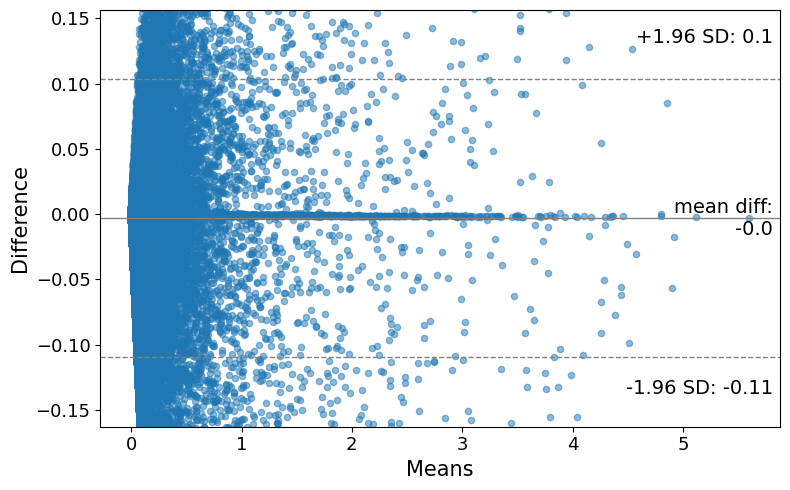

In [79]:
subject = 'NDARBF575JUL'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 4. NDARBY976XYY

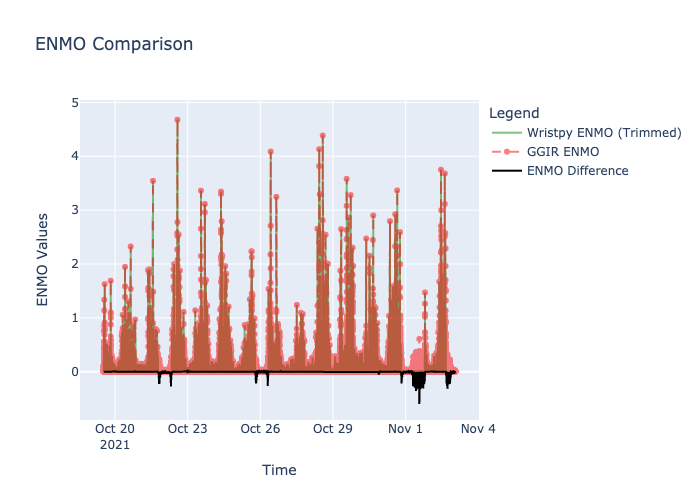

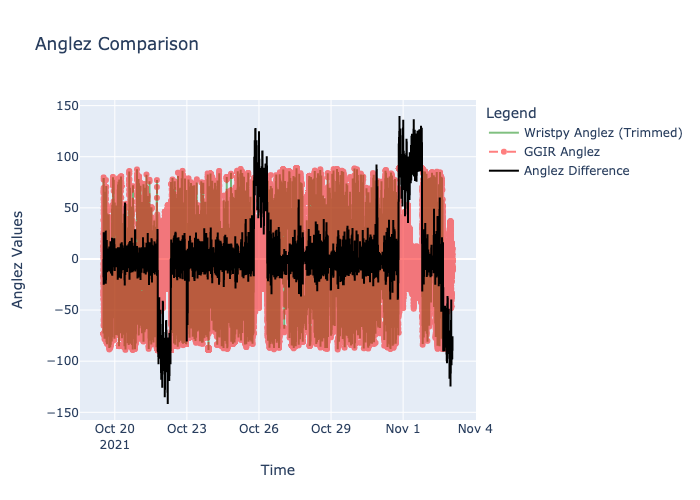

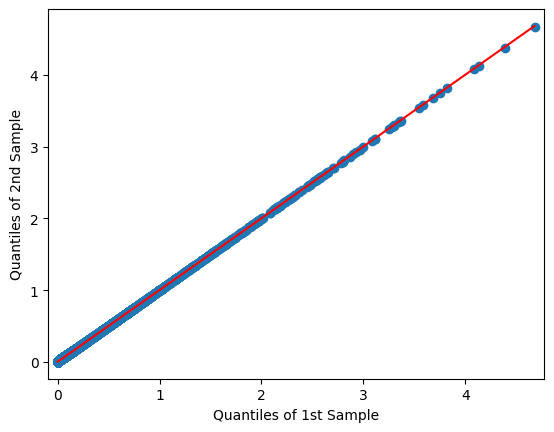

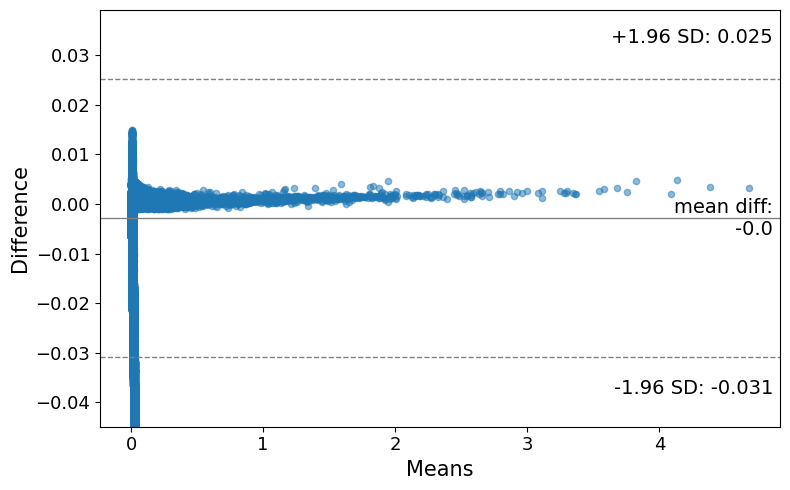

In [83]:
subject = 'NDARBY976XYY'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 5. NDARFE868RRJ ***

* ENMO:
    * ENMO signal differences seem to follow similar patterns noted previously relating to non-wear time and the triggering of idle-sleep mode.
    * Starting Dec-30th (first full day) GGIR reports single value of activity, that repeats through out dataset.
        * Value is always 1.2371 and always at 8:14. 
    * when wristpy stops reporting activity, GGIR seems to "trail off" creating the repeated error spike after the main period of activity as seen below. 
        * Doesn't seem like this should be caused by any idle-sleep mode data fill in, unsure as to cause.
    * 8:14 Spike seems to demark the end of the non-wear/sleep time and the beginning of activity.
        * in activity time of about  ~8 hours 00:00 - 8:14 does not seem to trigger GGIR data- filling in during non-wear time.

* AngleZ
    * Similar pattern
    * during period of near zero enmo data wristpy registers anglez of ~ +/- 90 degrees, GGIR reports exactly 0
    


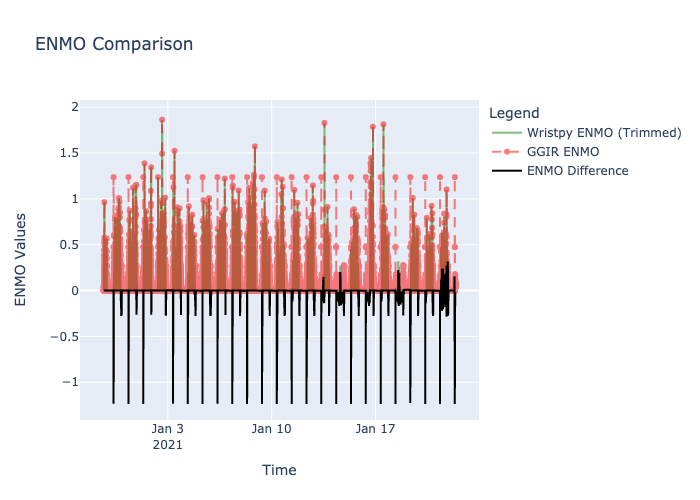

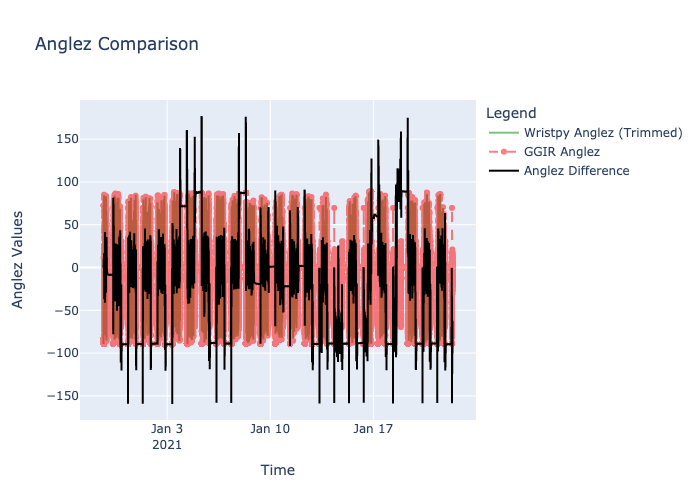

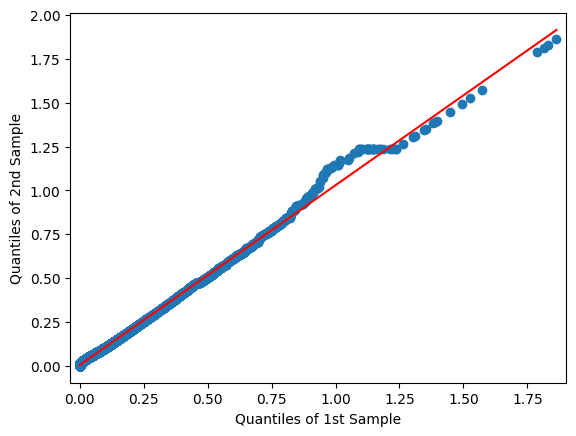

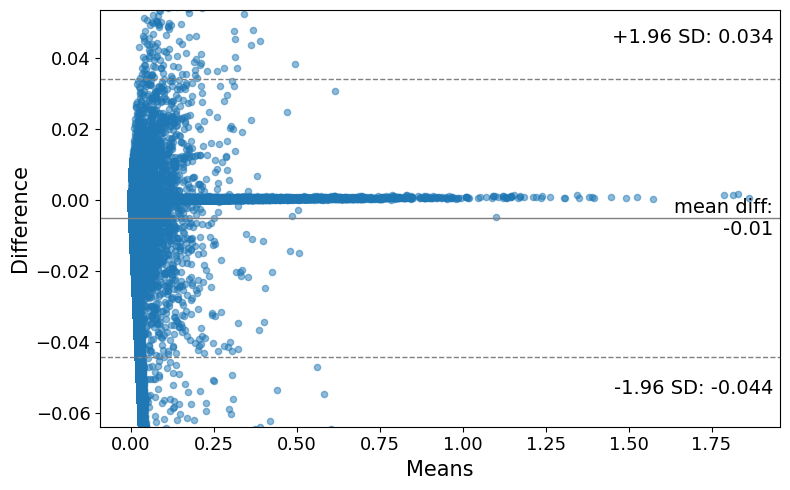

In [53]:
subject = 'NDARFE868RRJ'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 6. NDARGB101GUF

* non- wear fill in signal does adjust, and begin to match our data ~ 2 hours after wristpy begins reporting activity again
    * see May 13 at around 13:30 
* low amounts of activity in following day, GGIR seems to return to filling in data. 

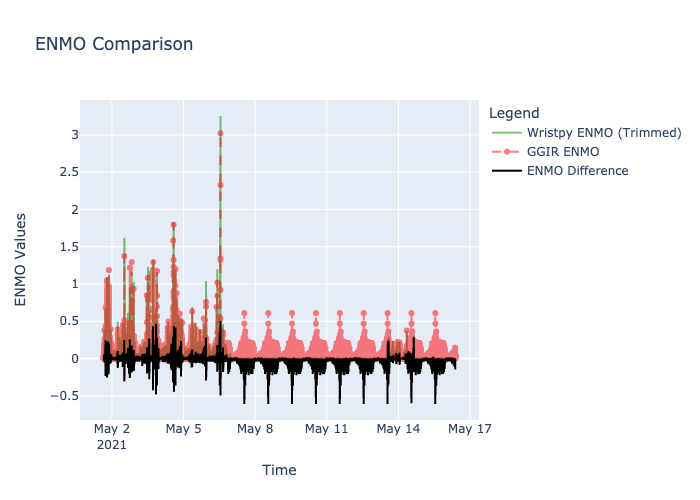

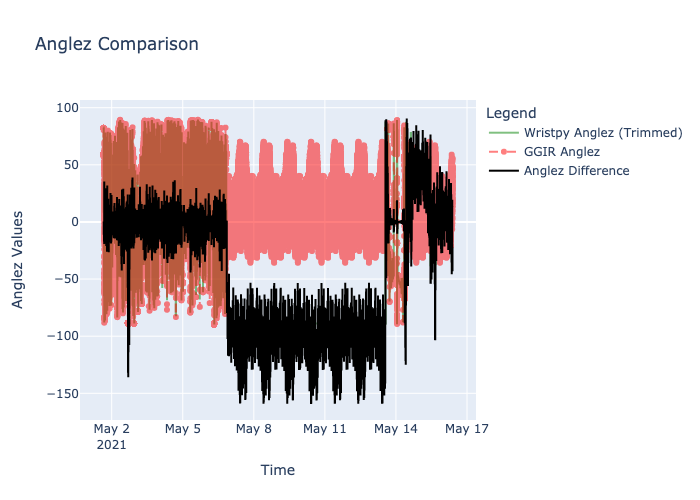

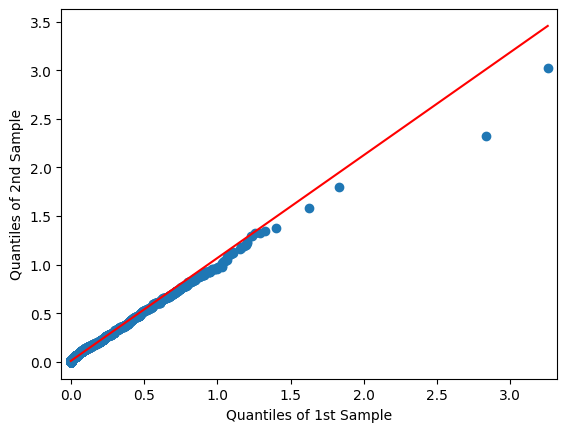

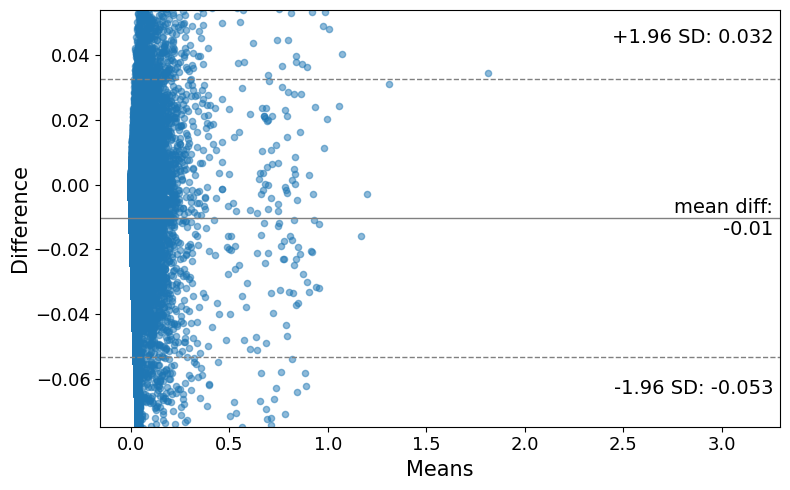

In [54]:
subject = 'NDARGB101GUF'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 7. NDARHU018AT3

* error seems to increase with no apparant cause in the middle of day (~12:00 April 17),
    * unclear if this is a result of idle-sleep mode. 
    * similar effect seen in angleZ
    

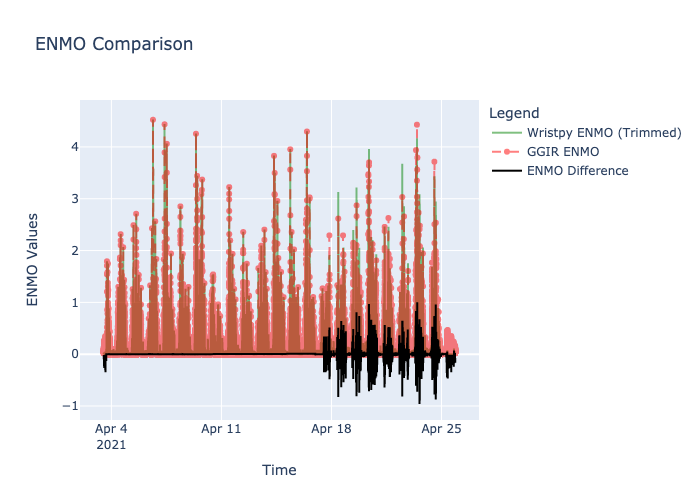

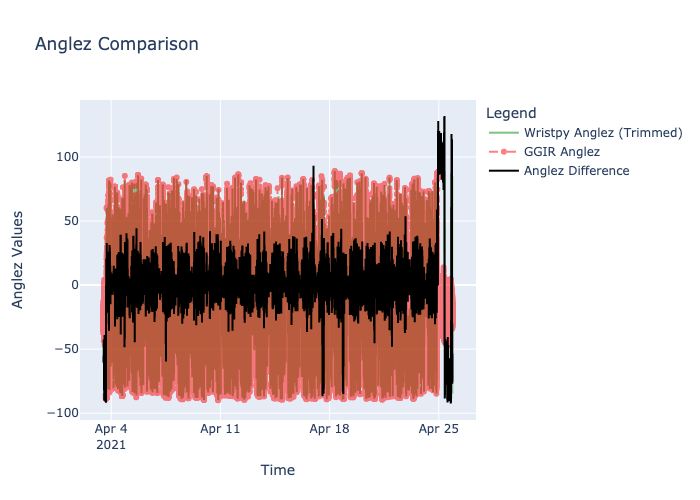

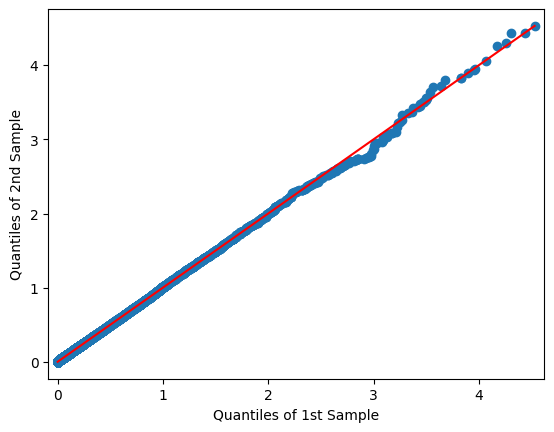

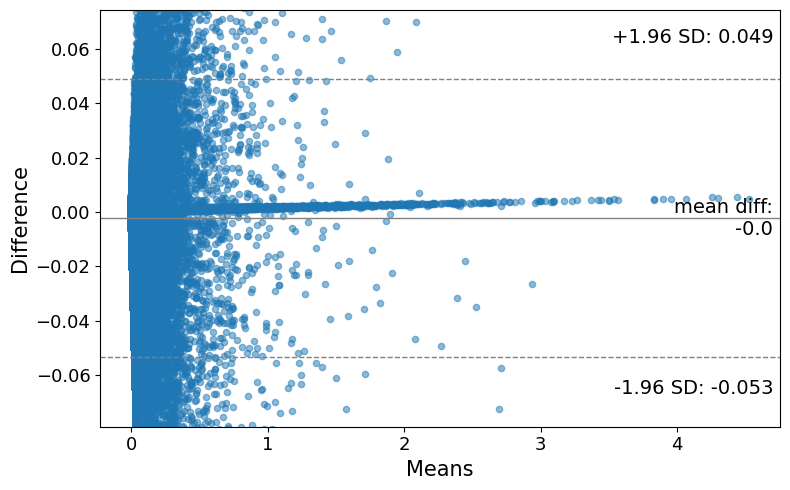

In [55]:
subject = 'NDARHU018AT3'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 8. NDARLM287VZ9 ERROR

In [ ]:
subject = 'NDARLM287VZ9'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

ValueError: not enough values to unpack (expected 5, got 3)

## 9. NDARPJ763DV1

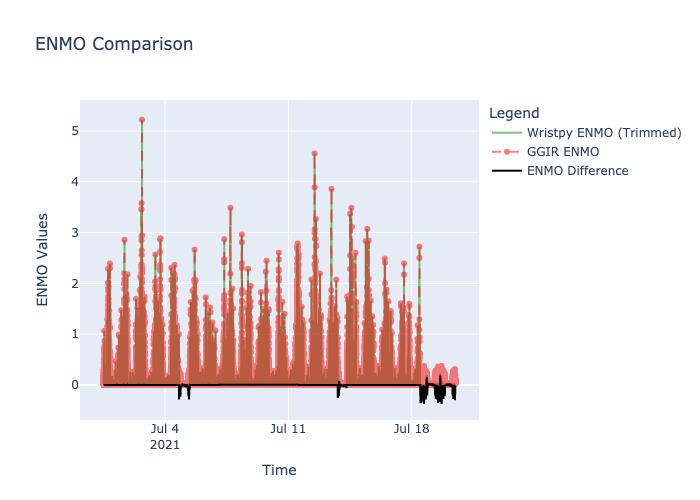

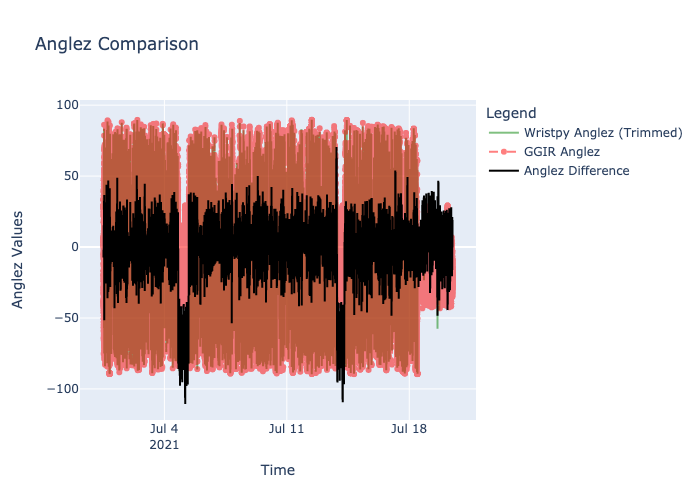

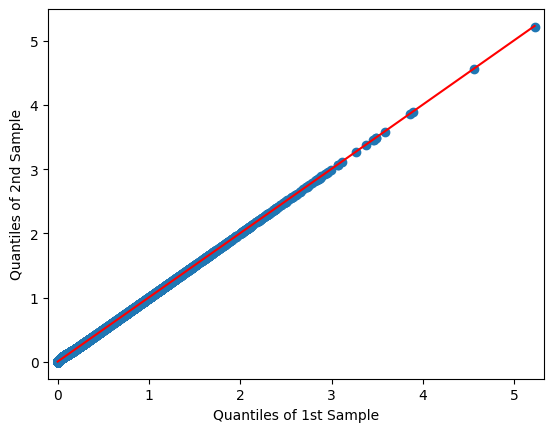

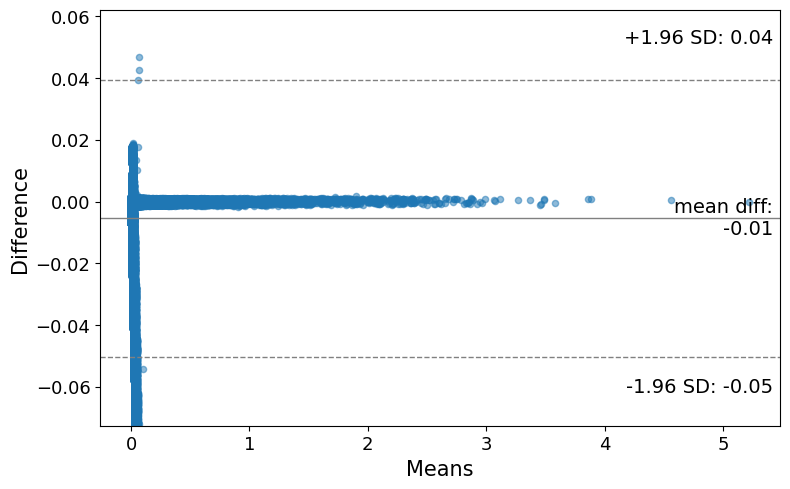

In [56]:
subject = 'NDARPJ763DV1'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 10. NDARTC071WDB

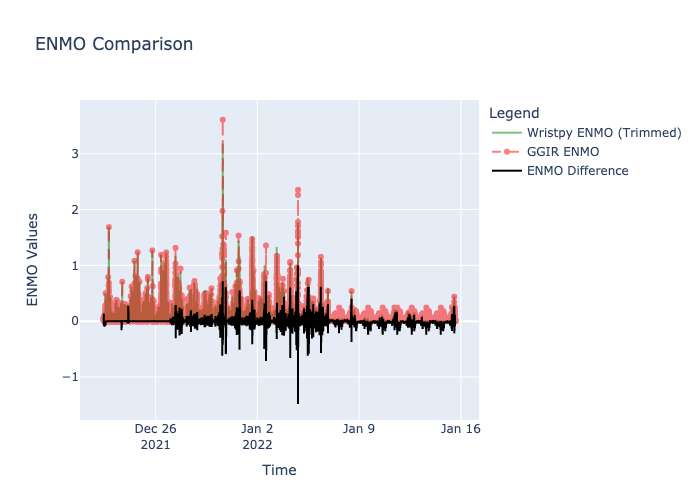

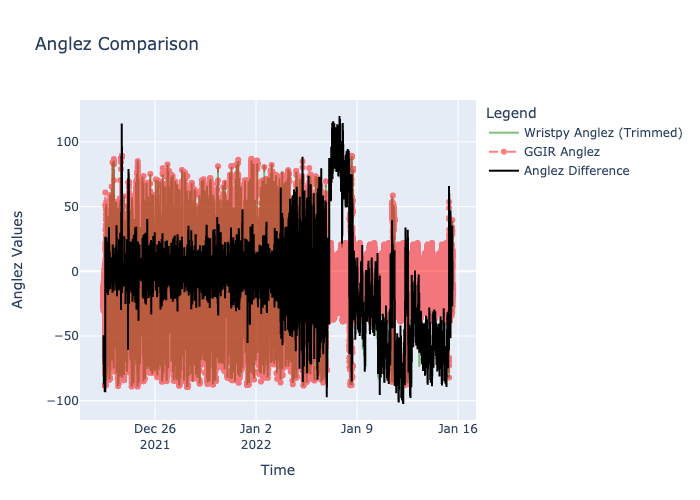

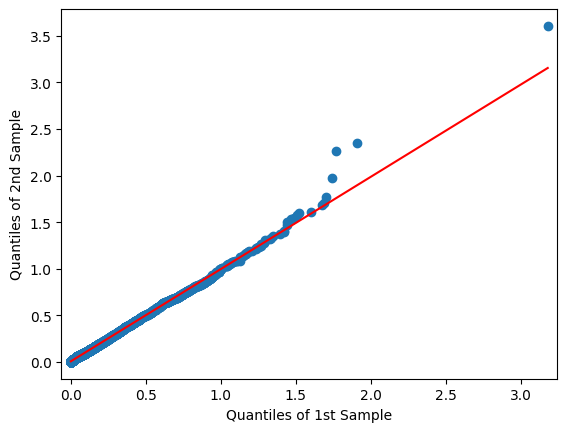

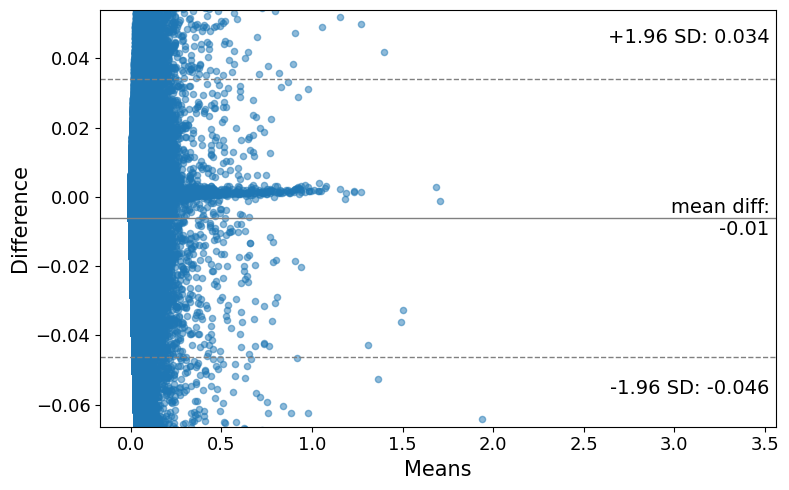

In [57]:
subject = 'NDARTC071WDB'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 11. NDARUM301RDE

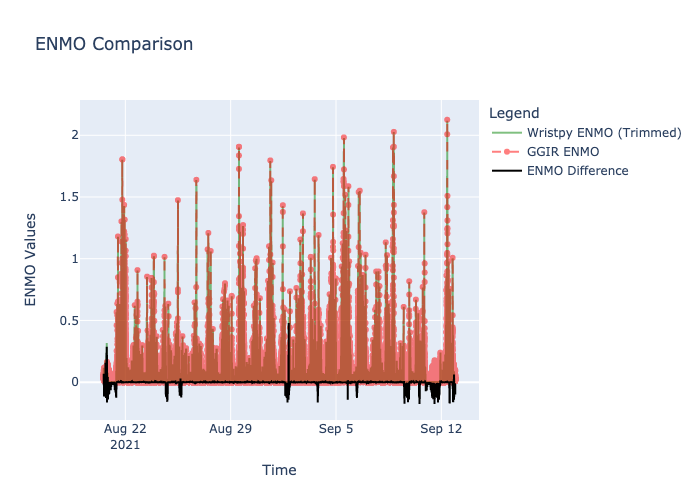

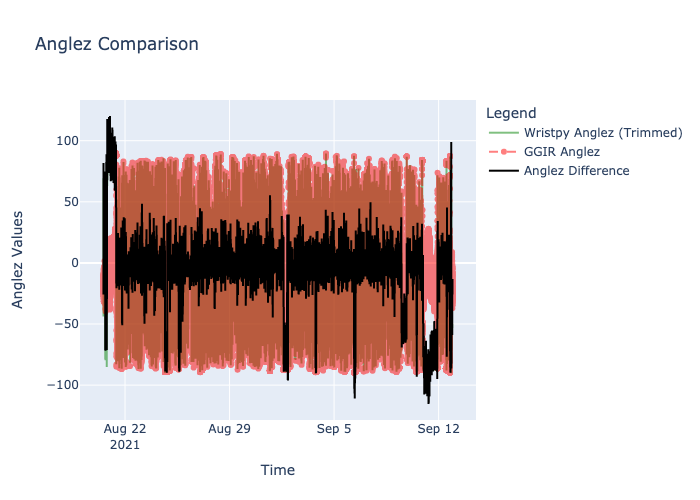

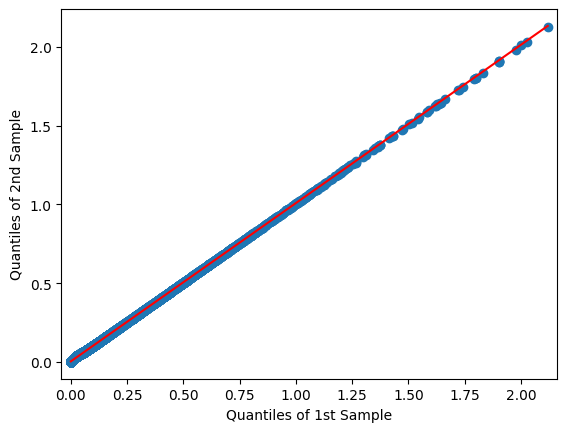

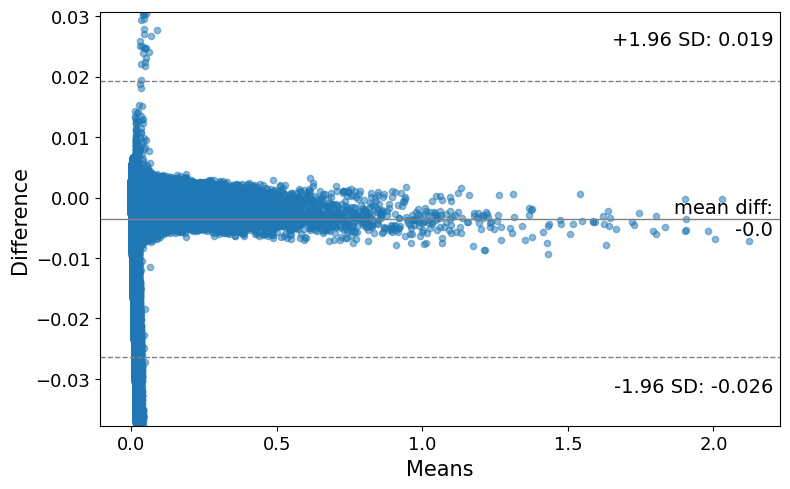

In [58]:
subject = 'NDARUM301RDE'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 12. NDARUR724ZHG ERROR

In [16]:
subject = 'NDARUR724ZHG'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

thread '<unnamed>' panicked at crates/polars-core/src/chunked_array/ops/arity.rs:817:14:
Cannot apply operation on arrays of different lengths
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: Cannot apply operation on arrays of different lengths

## 13. NDARUW377KAE

* Another increase in error, cause unclear.

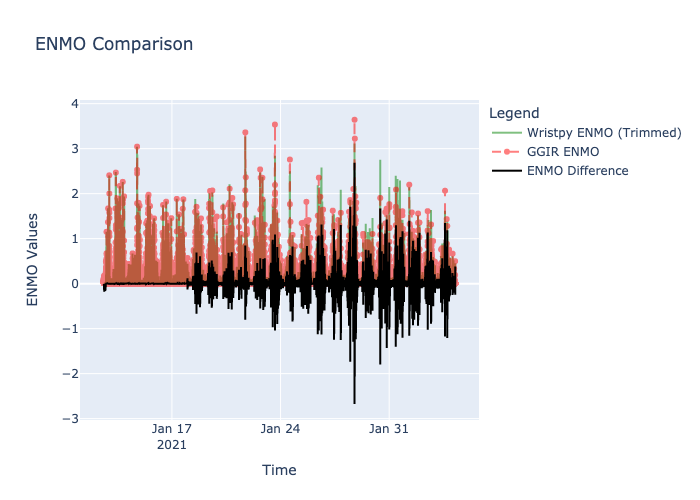

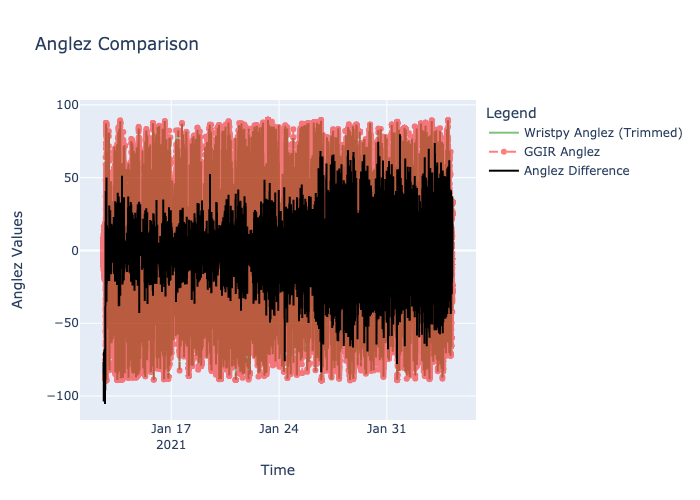

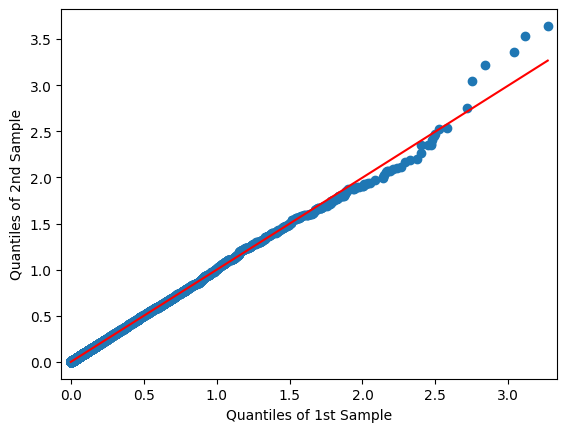

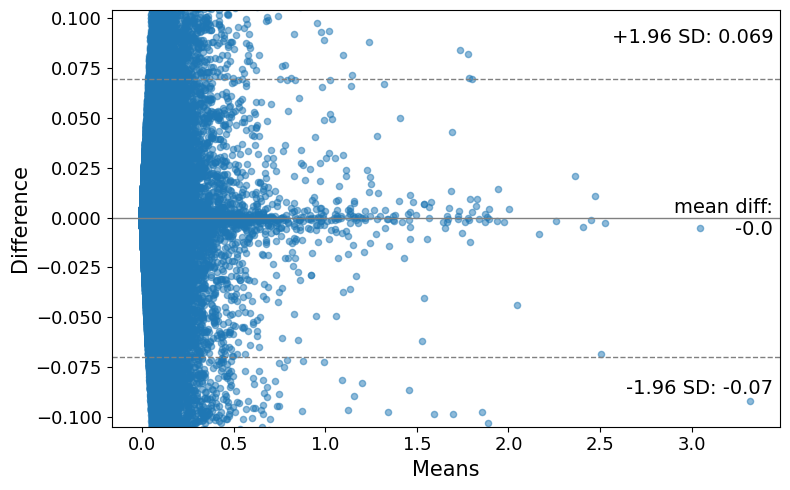

In [59]:
subject = 'NDARUW377KAE'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 14. NDARVC874KGR

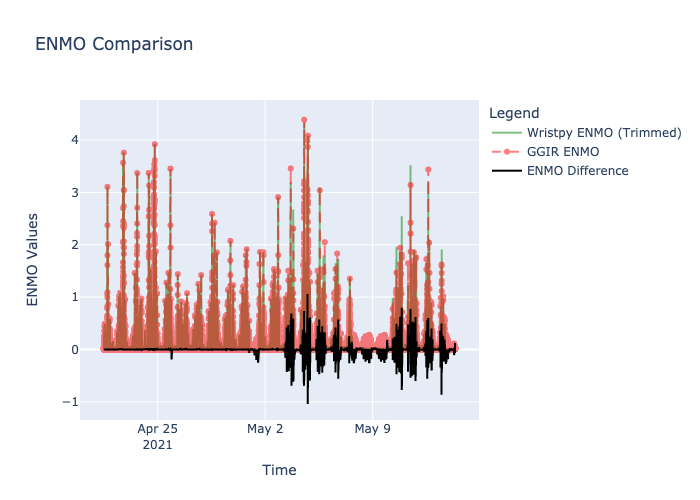

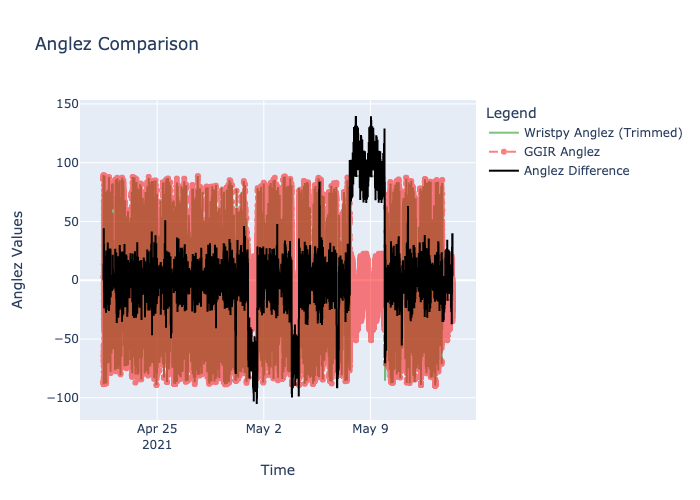

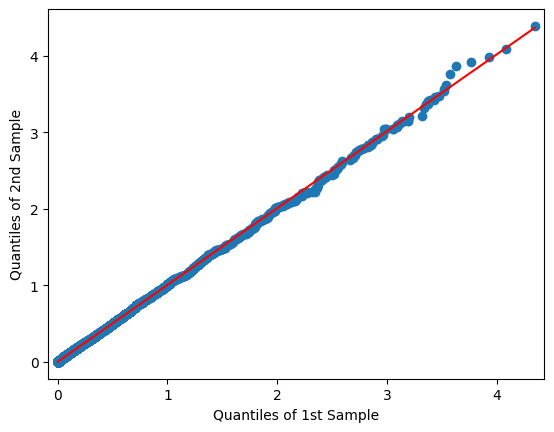

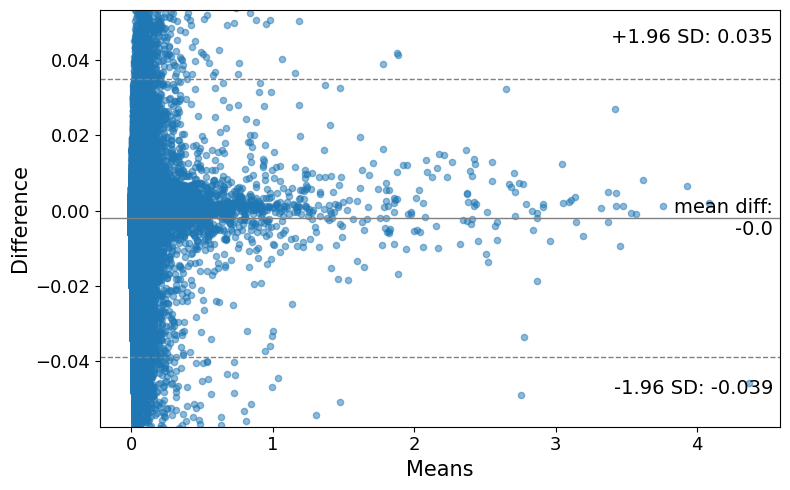

In [60]:
subject = 'NDARVC874KGR'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 15. NDARVM557ZLF

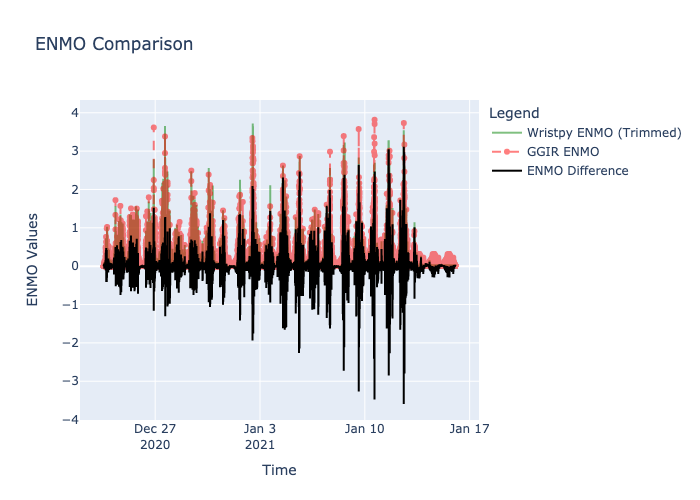

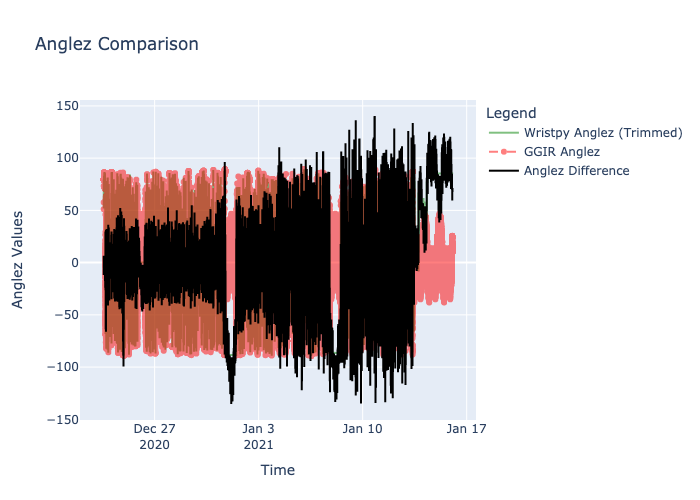

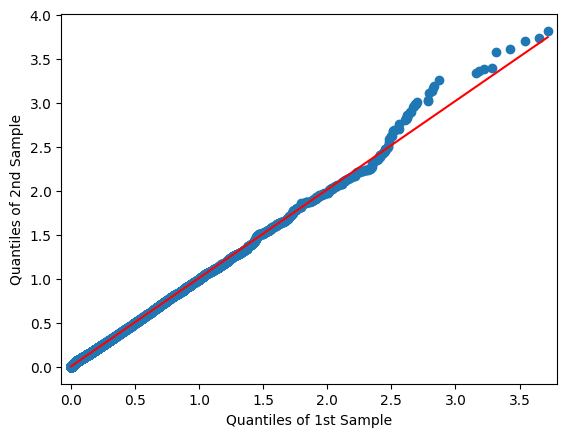

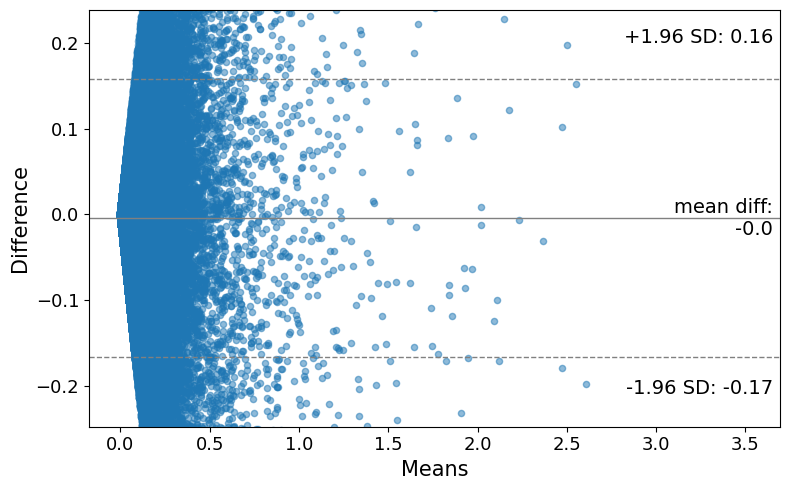

In [61]:
subject = 'NDARVM557ZLF'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 16. NDARWN682PGV ERROR NOT ENOUGH DATA


In [21]:
subject = 'NDARWN682PGV'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

AttributeError: 'dict' object has no attribute 'cal_acceleration'

## 17. NDARXK986EK6

Wrong freq cases: [60]


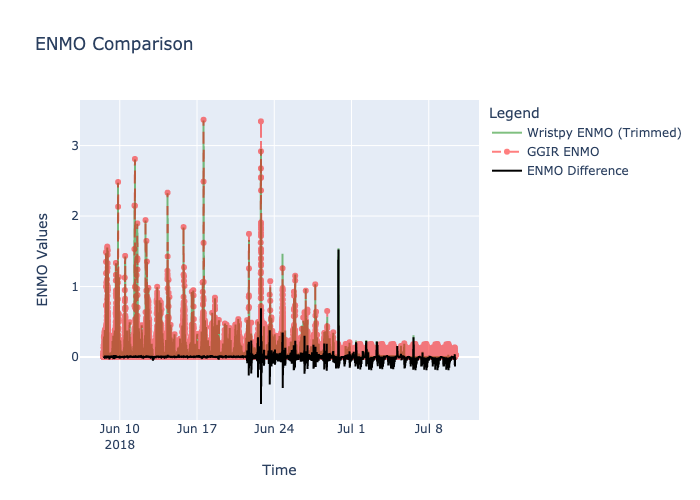

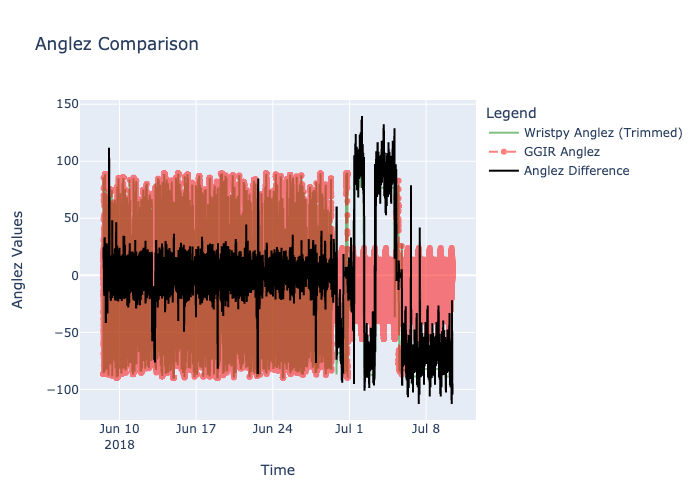

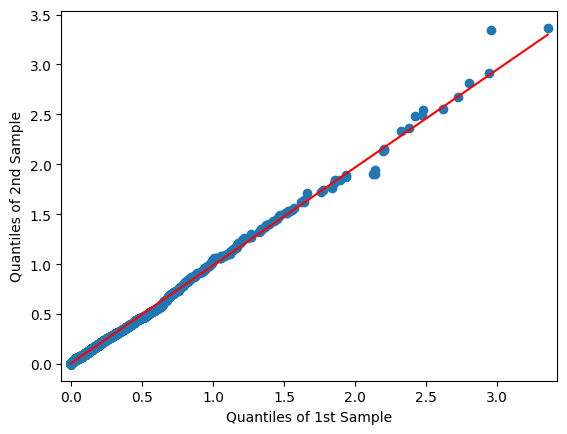

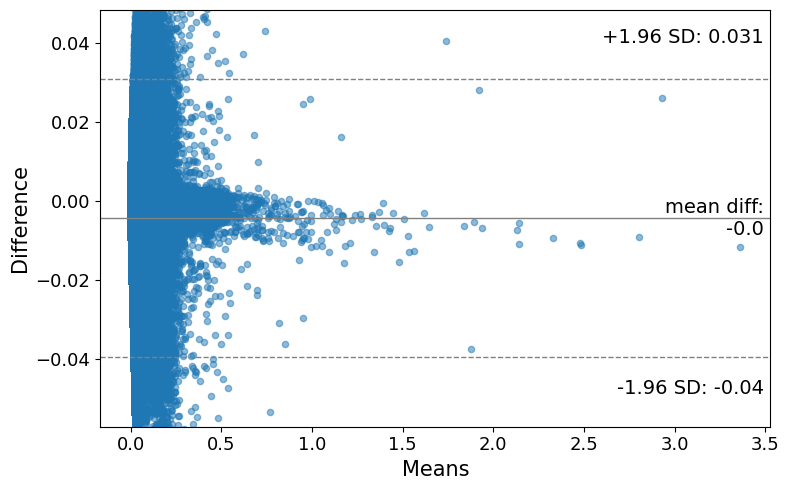

In [62]:
subject = 'NDARXK986EK6'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 18. NDARYK713TGJ

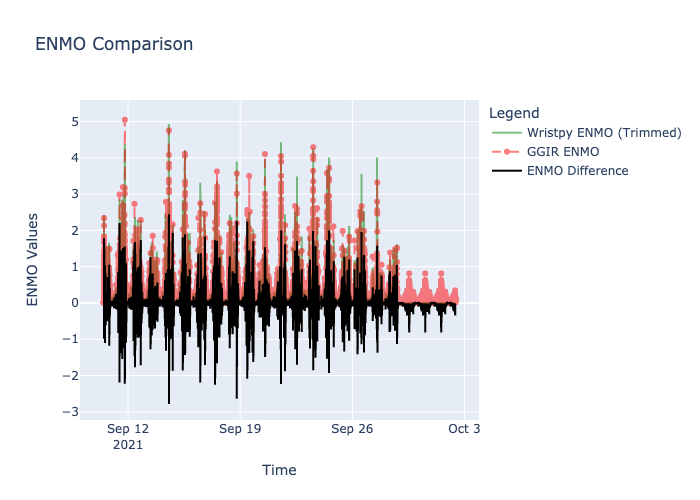

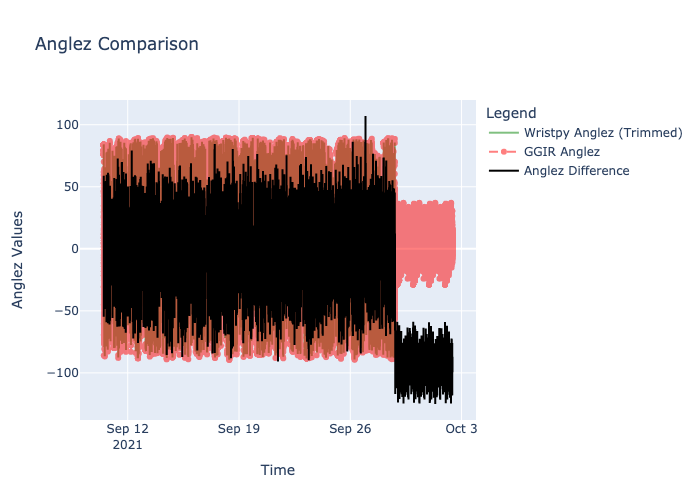

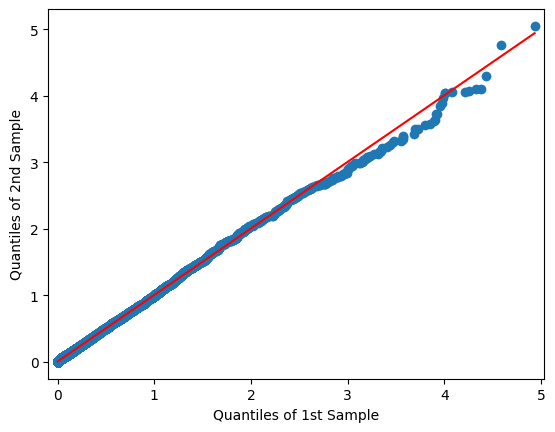

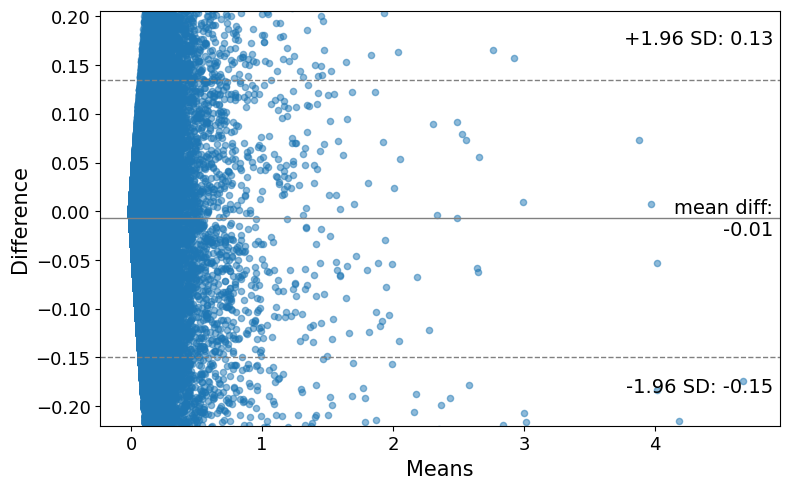

In [63]:
subject = 'NDARYK713TGJ'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 19. NDARZN702ECL

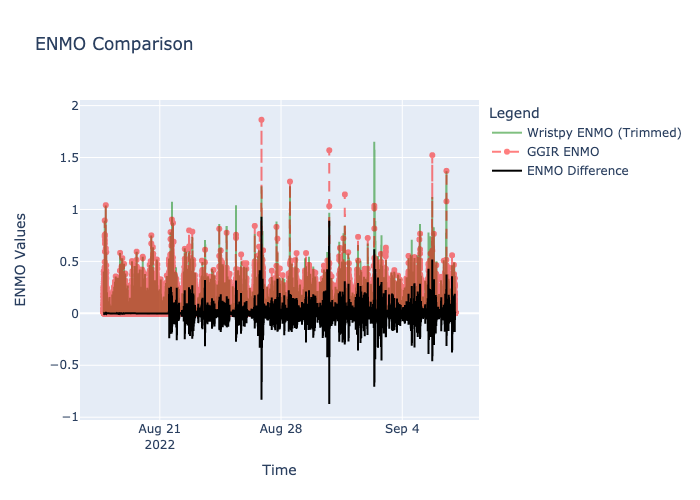

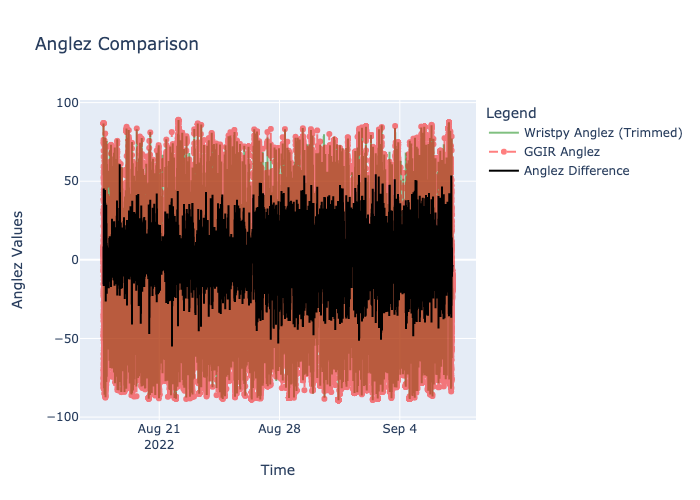

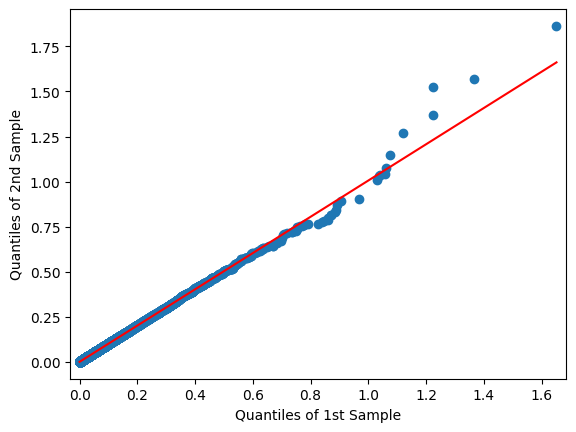

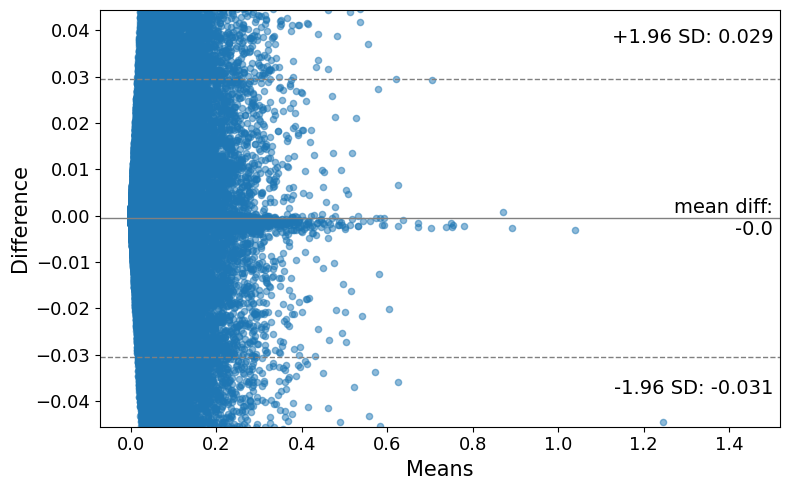

In [64]:
subject = 'NDARZN702ECL'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)

## 20. NDARZR293TKN

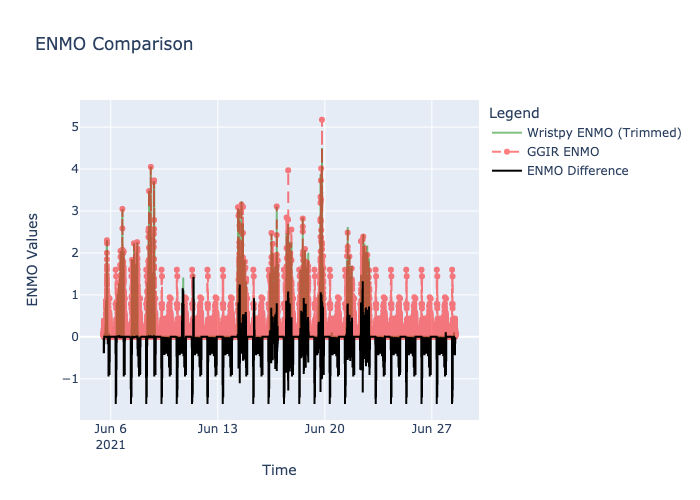

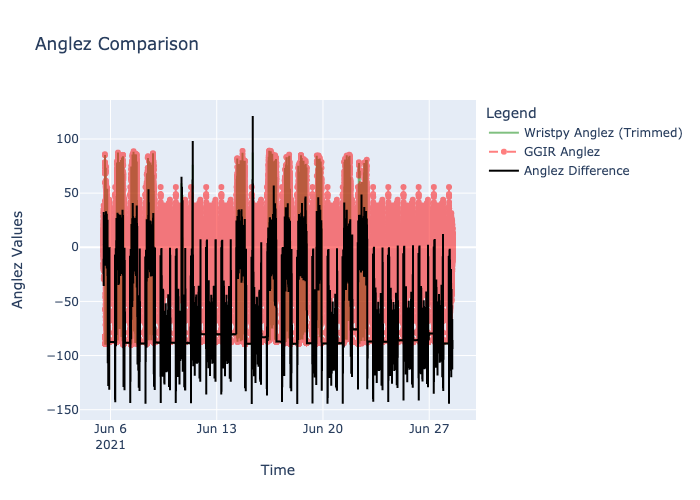

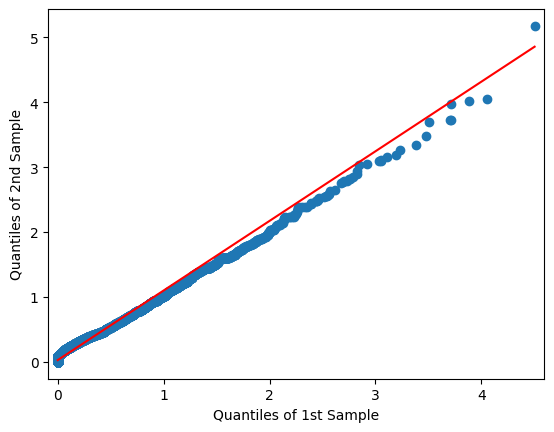

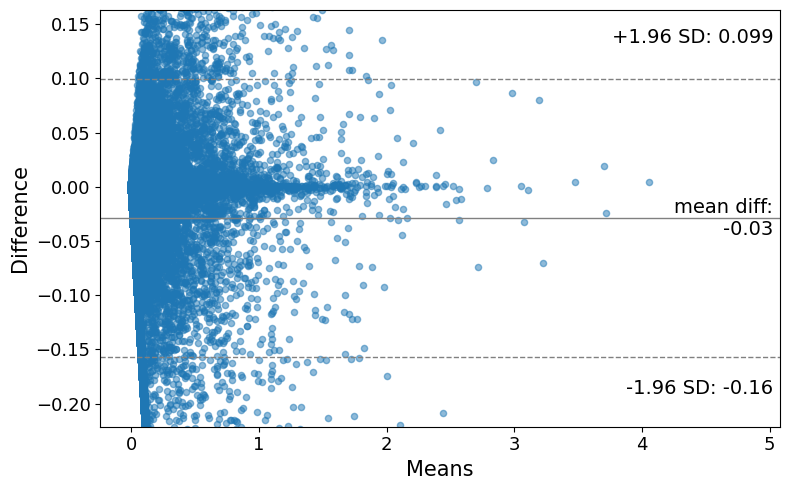

In [65]:
subject = 'NDARZR293TKN'
notebook_runner(path_to_raw + subject + '.gt3x',
                path_to_ggir_output + subject + '.gt3x.RData.csv',
                ['ENMO', 'anglez', 'qq', 'ba'],
                save_plot = True,
                save_path = path_to_save + subject)